In [1]:
from pathlib import Path
from numbers import Number
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import h5py
from contrastive import CPCA
from sklearn.ensemble import IsolationForest
sns.set()

In [2]:
gleason_table_path = Path('/mnt/rescomp/projects/TCGA_prostate/TCGA/data/gdc_download_20190827_173135.969230/06efd272-a76f-4703-98b8-dfa751c0f019/nationwidechildrens.org_clinical_patient_prad.txt')
gleason_table = pd.read_csv(gleason_table_path, delimiter='\t', skiprows=lambda x: x in [1, 2])

In [21]:
print(sorted(gleason_table.columns))

['age_at_initial_pathologic_diagnosis', 'bcr_patient_barcode', 'bcr_patient_uuid', 'biochemical_recurrence_indicator', 'birth_days_to', 'bone_scan_results', 'cause_of_death', 'cause_of_death_source', 'clinical_M', 'clinical_N', 'clinical_T', 'clinical_stage', 'ct_scan_ab_pelvis_indicator', 'ct_scan_ab_pelvis_results', 'days_to_biochemical_recurrence_first', 'days_to_bone_scan', 'days_to_ct_scan_ab_pelvis', 'days_to_initial_pathologic_diagnosis', 'days_to_mri', 'days_to_psa_most_recent', 'death_days_to', 'diagnostic_mri_performed', 'disease_code', 'ethnicity', 'extranodal_involvement', 'form_completion_date', 'gender', 'gleason_pattern_primary', 'gleason_pattern_secondary', 'gleason_pattern_tertiary', 'gleason_score', 'histologic_diagnosis', 'histologic_diagnosis_other', 'history_neoadjuvant_treatment', 'history_other_malignancy', 'icd_10', 'icd_o_3_histology', 'icd_o_3_site', 'informed_consent_verified', 'initial_pathologic_diagnosis_method', 'initial_pathologic_dx_year', 'last_contact

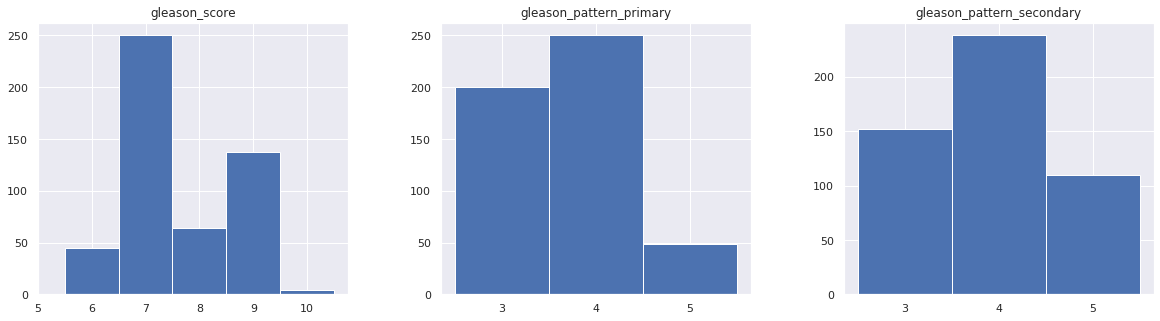

In [3]:
# Plot distribution of primary and secondary patterns
def replace_string_value(el):
    if isinstance(el, str):
        if el.isdigit():
            el = int(el)
        else:
            el = -1
    return el
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
gleason_pattern_primary = gleason_table.loc[:, 'gleason_score'].to_frame().applymap(replace_string_value)
gleason_pattern_primary[gleason_pattern_primary != -1].hist(bins=[5.5, 6.5, 7.5, 8.5, 9.5, 10.5], ax=axes[0])
gleason_pattern_primary = gleason_table.loc[:, 'gleason_pattern_primary'].to_frame().applymap(replace_string_value)
gleason_pattern_primary[gleason_pattern_primary != -1].hist(bins=[2.5, 3.5, 4.5, 5.5], ax=axes[1])
gleason_pattern_primary = gleason_table.loc[:, 'gleason_pattern_secondary'].to_frame().applymap(replace_string_value)
gleason_pattern_primary[gleason_pattern_primary != -1].hist(bins=[2.5, 3.5, 4.5, 5.5], ax=axes[2])
axes[0].set_xticks([5, 6, 7, 8, 9, 10])
axes[1].set_xticks([3, 4, 5])
axes[2].set_xticks([3, 4, 5])
# primary pattern is most widespread pattern, second pattern is pattern with the highest score

In [57]:
def replace_string_value(el):
    if isinstance(el, str):
        try:
            el = float(el)
        except ValueError:
            el = -1
    return el
# convert strings to floats
psa_values = gleason_table['psa_most_recent_results'].to_frame().applymap(replace_string_value)
print(np.unique(psa_values))
# remove zeros
n_before = len(psa_values)
psa_values = psa_values[psa_values > 0.0]
print(f"removed  {n_before - len(psa_values)} samples")
print(psa_values.median())

[-1.000e+00  0.000e+00  1.000e-02  1.500e-02  1.900e-02  2.000e-02
  2.400e-02  3.000e-02  4.000e-02  5.000e-02  5.900e-02  6.000e-02
  6.400e-02  7.000e-02  8.000e-02  9.000e-02  9.900e-02  1.000e-01
  1.100e-01  1.200e-01  1.300e-01  1.400e-01  1.500e-01  1.600e-01
  1.800e-01  1.900e-01  2.000e-01  2.300e-01  2.400e-01  2.500e-01
  2.800e-01  3.000e-01  3.200e-01  3.600e-01  3.700e-01  3.800e-01
  4.000e-01  4.200e-01  4.800e-01  5.000e-01  5.300e-01  5.500e-01
  6.000e-01  6.500e-01  6.520e-01  7.000e-01  7.300e-01  7.600e-01
  8.000e-01  8.300e-01  9.000e-01  9.500e-01  1.000e+00  1.100e+00
  1.130e+00  1.360e+00  1.440e+00  1.600e+00  1.800e+00  2.190e+00
  3.000e+00  3.100e+00  3.110e+00  3.150e+00  3.260e+00  3.270e+00
  3.370e+00  3.500e+00  3.580e+00  4.090e+00  4.300e+00  4.530e+00
  5.040e+00  5.220e+00  6.400e+00  7.420e+00  7.820e+00  8.490e+00
  9.630e+00  9.690e+00  1.080e+01  1.087e+01  1.090e+01  1.116e+01
  1.149e+01  1.201e+01  1.390e+01  1.395e+01  1.469e+01  1.560

(array([ 68.,  73., 184.,  25.,  24.,  17.,  15.,   7.,   0.,   1.]),
 array([-4.60517019, -3.56688794, -2.52860568, -1.49032343, -0.45204118,
         0.58624107,  1.62452332,  2.66280557,  3.70108782,  4.73937007,
         5.77765232]),
 <a list of 10 Patch objects>)

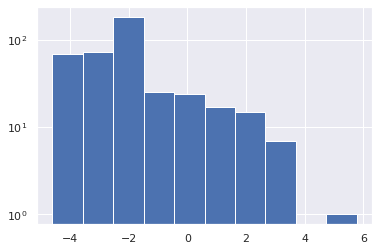

In [49]:
plt.hist(np.log(psa_values.values), log=True)

In [50]:
gleason_table

,bcr_patient_uuid,bcr_patient_barcode,form_completion_date,histologic_diagnosis,histologic_diagnosis_other,zone_of_origin,gleason_pattern_primary,gleason_pattern_secondary,gleason_score,gleason_pattern_tertiary,...,pathologic_M,pathologic_N,pathologic_T,pathologic_stage,patient_id,project_code,stage_other,system_version,tissue_source_site,tumor_tissue_site
0,49197847-CC83-4CE1-8397-D09CEA4C4928,TCGA-2A-A8VL,2014-3-29,Prostate Adenocarcinoma Acinar Type,[Not Applicable],Peripheral Zone,3,3,6,4,...,[Not Applicable],N0,T2b,[Not Applicable],A8VL,[Not Available],[Not Available],[Not Applicable],2A,Prostate
1,91C0D161-2B59-4B7A-8C19-6D26DEA31849,TCGA-2A-A8VO,2014-3-30,Prostate Adenocarcinoma Acinar Type,[Not Applicable],Overlapping / Multiple Zones,3,3,6,4,...,[Not Applicable],[Not Available],T3a,[Not Applicable],A8VO,[Not Available],[Not Available],[Not Applicable],2A,Prostate
2,931B549F-B9F2-4E8D-83ED-FF663671883C,TCGA-2A-A8VT,2014-3-29,Prostate Adenocarcinoma Acinar Type,[Not Applicable],Overlapping / Multiple Zones,4,5,9,[Not Available],...,[Not Applicable],N1,T4,[Not Applicable],A8VT,[Not Available],[Not Available],[Not Applicable],2A,Prostate
3,75A7AFB5-66D5-47E3-8A8A-3E3A1E749A96,TCGA-2A-A8VV,2014-3-29,Prostate Adenocarcinoma Acinar Type,[Not Applicable],Peripheral Zone,3,3,6,4,...,[Not Applicable],N0,T2b,[Not Applicable],A8VV,[Not Available],[Not Available],[Not Applicable],2A,Prostate
4,942F1788-D977-4AC0-A177-659F9D4CD077,TCGA-2A-A8VX,2014-3-29,Prostate Adenocarcinoma Acinar Type,[Not Applicable],Peripheral Zone,4,4,8,[Not Available],...,[Not Applicable],N0,T3b,[Not Applicable],A8VX,[Not Available],[Not Available],[Not Applicable],2A,Prostate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,9B5D36B2-8B46-48A4-AFA7-0E1936F2D315,TCGA-ZG-A9M4,2014-7-18,Prostate Adenocarcinoma Acinar Type,[Not Applicable],Overlapping / Multiple Zones,5,4,9,[Not Available],...,[Not Applicable],N1,T3b,[Not Applicable],A9M4,[Not Available],[Not Available],[Not Applicable],ZG,Prostate
496,7EFC26B2-EFF9-4F1E-9F4B-F26AF072C84A,TCGA-ZG-A9MC,2014-7-18,Prostate Adenocarcinoma Acinar Type,[Not Applicable],Peripheral Zone,5,4,9,3,...,[Not Applicable],N1,T3b,[Not Applicable],A9MC,[Not Available],[Not Available],[Not Applicable],ZG,Prostate
497,305B0B57-5952-43C7-9063-7BCD954EB44D,TCGA-ZG-A9N3,2014-7-18,Prostate Adenocarcinoma Acinar Type,[Not Applicable],Overlapping / Multiple Zones,5,4,9,3,...,[Not Applicable],N1,T3b,[Not Applicable],A9N3,[Not Available],[Not Available],[Not Applicable],ZG,Prostate
498,348C2BF3-2146-4990-9ADF-FA6968B4F072,TCGA-ZG-A9ND,2014-7-18,Prostate Adenocarcinoma Acinar Type,[Not Applicable],Overlapping / Multiple Zones,5,4,9,3,...,[Not Applicable],N0,T3a,[Not Applicable],A9ND,[Not Available],[Not Available],[Not Applicable],ZG,Prostate


In [5]:
#
print(list(gleason_table['tumor_status'].unique()))
print(list(gleason_table['histologic_diagnosis'].unique()))
print(list(gleason_table['death_days_to'].unique()))

['TUMOR FREE', '[Discrepancy]', '[Unknown]', 'WITH TUMOR', '[Not Available]']
['Prostate Adenocarcinoma Acinar Type', 'Prostate Adenocarcinoma, Other Subtype']
['[Not Applicable]', '791', '1329', '3467', '628', '728', '146', '875', '1855']


In [6]:
# number of deaths
num_deaths = np.sum(1 if n.isdigit() else 0 for n in list(gleason_table['death_days_to'].unique()))
print(f"Dead patients: {num_deaths}/{gleason_table.shape[0]}")

Dead patients: 8/500


/home/andrea/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


In [7]:
# Inspect MRI labels
print(list(gleason_table['mri_results'].unique()))

['[Not Available]', 'Extraprostatic Extension Localized (e.g. seminal vesicles)', 'No Evidence of Extraprostatic Extension', 'Equivocal', 'Extraprostatic Extension Localized (e.g. seminal vesicles)|Extraprostatic Extension (regional lymphadenopathy) [e.g. cN1]', 'No Evidence of Extraprostatic Extension|Equivocal', 'Distant Metastasis [e.g. cM1]']


In [8]:
# import foreground data (features)
features_path = Path('/mnt/rescomp/projects/TCGA_prostate/TCGA/data/features/mpp0.4_active_learn_14f/single_key.h5')
features = pd.read_hdf(features_path, key='features')

In [9]:
gleason_table[gleason_table['bcr_patient_barcode'] == features.index[0][0][:12]]['gleason_score'].iloc[0]

6

In [10]:
# remove outliers:
n_before = len(features)
inliers = list(bool(label != -1) for label in IsolationForest(behaviour='new').fit_predict(features))
features = features.loc[inliers]
print(f"# removed outliers = {n_before- len(features)}")

/home/andrea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


# removed outliers = 11646


In [11]:
# extract gleason score for each gland
features_gleason = []
missing = []
for (slide_id, bb), row in features.iterrows():
    row = gleason_table[gleason_table['bcr_patient_barcode'] == slide_id[:12]]
    if row.empty:
        missing.append((slide_id, bb))
        features_gleason.append(-1)
    else:
        features_gleason.append(row['gleason_score'].iloc[0])

In [12]:
print(np.unique(features_gleason))
print(len(missing))

[ 6  7  8  9 10]
0


In [13]:
background_indices = np.where(np.array(features_gleason) != 7)[0]
foreground_indices = np.where(np.array(features_gleason) == 7)[0]
background_features = features.iloc[background_indices]
foreground_features = features.iloc[foreground_indices]
print(background_features.shape, foreground_features.shape)

(55670, 100) (49143, 100)


In [61]:
# construct 3+4 vs 4+3 labels
labels = []
for (slide_id, bb), row in foreground_features.iterrows():
    row = gleason_table[gleason_table['bcr_patient_barcode'] == slide_id[:12]]
    if row['gleason_pattern_primary'].iloc[0] == 3 and row['gleason_pattern_secondary'].iloc[0] == 4:
        labels.append(0)
    elif row['gleason_pattern_primary'].iloc[0] == 4 and row['gleason_pattern_secondary'].iloc[0] == 3:
        labels.append(1)
    else:
        raise ValueError("shouldn't be here")
print(len(labels))
sum(labels)

49143


23689

In [15]:
# test cpca with 3+4 vs 4+3 labels
cpca = CPCA()
projected_data = cpca.fit_transform(foreground_features, background_features, active_labels=labels, gui=True)

The GUI may be slow to respond with large numbers of data points. Consider using a subset of the original data.


interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='\\(\\log_{10}{\\alpha} \\)'…

In [59]:
# constrct psa < 1.0 and psa > 1.0 labels
# construct 3+4 vs 4+3 labels
def replace_string_value(el):
    if isinstance(el, str):
        try:
            el = float(el)
        except ValueError:
            el = -1
    return el
labels = []
for (slide_id, bb), row in foreground_features.iterrows():
    row = gleason_table[gleason_table['bcr_patient_barcode'] == slide_id[:12]]
    value = replace_string_value(row['psa_most_recent_results'].iloc[0])
    if value > 0.1:
        labels.append(1)
    else:
        labels.append(0)
print(len(labels))
print(sum(labels))

49143
7612


In [60]:
# test cpca with psa label
cpca = CPCA()
projected_data = cpca.fit_transform(foreground_features, background_features, active_labels=labels, gui=True)

The GUI may be slow to respond with large numbers of data points. Consider using a subset of the original data.


interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='\\(\\log_{10}{\\alpha} \\)'…